In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import torch
import torch.nn as nn
import dtnnlib as dtnn

In [3]:
from sklearn.datasets import make_classification, make_blobs

In [4]:
def twospirals(n_points, noise=.5, angle=784):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * angle * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [5]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

## Viz Residual

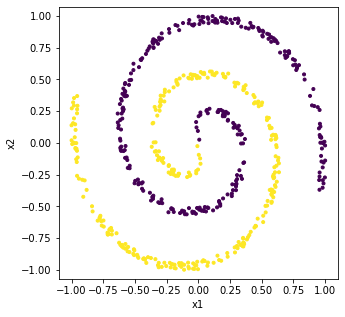

In [6]:
x, y = twospirals(300, angle=560)
x, y = x/x.max(axis=0, keepdims=True), y.reshape(-1)
xx, yy = torch.FloatTensor(x), torch.FloatTensor(y.reshape(-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(x1, x2, c=y, marker='.')
# plt.savefig("./clf_toy_data.pdf")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

In [7]:
xx, yy = xx.to(device), yy.to(device)

In [8]:
class SoftmaxTemp(nn.Module):
    def __init__(self, temp=3.0):
        super().__init__()
        self.temp = temp
        
    def forward(self, x):
        return torch.softmax(x*self.temp, dim=-1)

In [9]:
class ResidualMLP(nn.Module):
    
    def __init__(self, h):
        super().__init__()
        self.net = nn.Sequential(
#             dtnn.DistanceTransformBase(2, h),
            dtnn.DistanceTransform(2, h),
            nn.Sequential(dtnn.ScaleShift(h, scale_init=10, shift_init=None), ### Shift is learnable, scale is fixed
                            nn.Softmax(dim=-1)),
#             dtnn.DistanceTransform_MinExp(2, h, bias=False),
#             SoftmaxTemp(10.0),
#             nn.BatchNorm1d(h),
#             nn.ELU(),
#             dtnn.OneActiv(h, mode="relu"),
            dtnn.OneActiv(h, mode="exp_1.6"),
            nn.Linear(h, 2),
            )
        self.net[0].centers.data = torch.randn_like(self.net[0].centers)/3.
        self.clf = nn.Linear(2, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.clf(x + self.net(x)))
#         return torch.sigmoid(self.clf(self.net(x)))

In [10]:
net = ResidualMLP(10).to(device)
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

criterion = nn.BCELoss()
# criterion = nn.MSELoss()

_________________________
Epoch: 99, Acc:0.55, Loss:0.7079795002937317
Epoch: 199, Acc:0.56, Loss:0.7052057981491089
Epoch: 299, Acc:0.56, Loss:0.7024843692779541
Epoch: 399, Acc:0.57, Loss:0.6997999548912048
Epoch: 499, Acc:0.58, Loss:0.6971348524093628
Epoch: 599, Acc:0.59, Loss:0.694469690322876
Epoch: 699, Acc:0.59, Loss:0.6917876601219177
Epoch: 799, Acc:0.59, Loss:0.6890851259231567
Epoch: 899, Acc:0.56, Loss:0.6863836646080017
Epoch: 999, Acc:0.56, Loss:0.6837234497070312


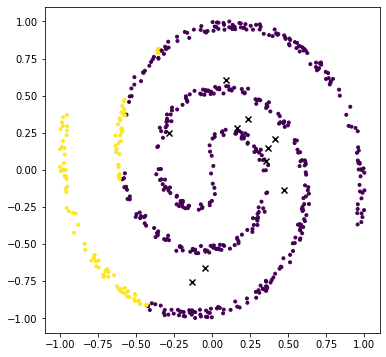

Epoch: 1099, Acc:0.56, Loss:0.6811387538909912
Epoch: 1199, Acc:0.55, Loss:0.6786425113677979
Epoch: 1299, Acc:0.55, Loss:0.6762325167655945
Epoch: 1399, Acc:0.56, Loss:0.6739003658294678
Epoch: 1499, Acc:0.56, Loss:0.6716375946998596
Epoch: 1599, Acc:0.57, Loss:0.6694371104240417
Epoch: 1699, Acc:0.57, Loss:0.6672930121421814
Epoch: 1799, Acc:0.57, Loss:0.6652008295059204
Epoch: 1899, Acc:0.57, Loss:0.6631568670272827
Epoch: 1999, Acc:0.57, Loss:0.6611579060554504


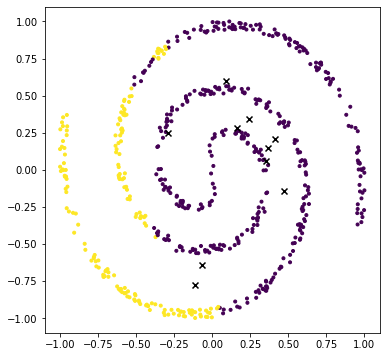

Epoch: 2099, Acc:0.57, Loss:0.6592015624046326
Epoch: 2199, Acc:0.57, Loss:0.6572855710983276
Epoch: 2299, Acc:0.57, Loss:0.6554079055786133
Epoch: 2399, Acc:0.57, Loss:0.6535668969154358
Epoch: 2499, Acc:0.57, Loss:0.651760995388031
Epoch: 2599, Acc:0.58, Loss:0.6499887108802795
Epoch: 2699, Acc:0.59, Loss:0.6482487320899963
Epoch: 2799, Acc:0.58, Loss:0.6465396881103516
Epoch: 2899, Acc:0.59, Loss:0.644860565662384
Epoch: 2999, Acc:0.60, Loss:0.6432101130485535


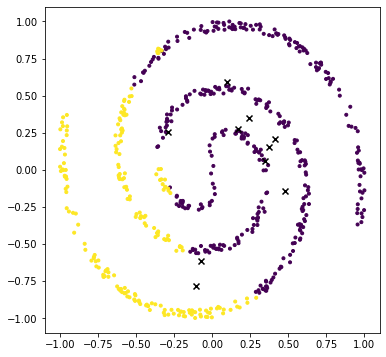

Epoch: 3099, Acc:0.60, Loss:0.6415873169898987
Epoch: 3199, Acc:0.61, Loss:0.639991283416748
Epoch: 3299, Acc:0.61, Loss:0.6384207606315613
Epoch: 3399, Acc:0.61, Loss:0.6368750333786011
Epoch: 3499, Acc:0.62, Loss:0.6353528499603271
Epoch: 3599, Acc:0.62, Loss:0.633853554725647
Epoch: 3699, Acc:0.63, Loss:0.6323761940002441
Epoch: 3799, Acc:0.63, Loss:0.6309197545051575
Epoch: 3899, Acc:0.63, Loss:0.6294835209846497
Epoch: 3999, Acc:0.64, Loss:0.6280665993690491


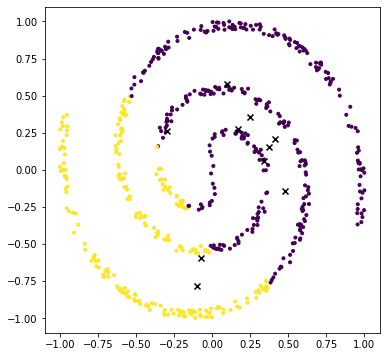

Epoch: 4099, Acc:0.64, Loss:0.6266682147979736
Epoch: 4199, Acc:0.64, Loss:0.6252875924110413
Epoch: 4299, Acc:0.64, Loss:0.6239241361618042
Epoch: 4399, Acc:0.64, Loss:0.6225771903991699
Epoch: 4499, Acc:0.64, Loss:0.6212460994720459
Epoch: 4599, Acc:0.64, Loss:0.6199304461479187
Epoch: 4699, Acc:0.64, Loss:0.6186298727989197
Epoch: 4799, Acc:0.63, Loss:0.6173440217971802
Epoch: 4899, Acc:0.63, Loss:0.6160725951194763
Epoch: 4999, Acc:0.63, Loss:0.6148154139518738


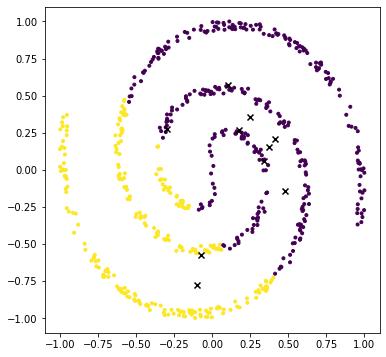

In [11]:
print("_________________________")
for epoch in range(5000):
    yout = net(xx)
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1)%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = (yout.data.cpu().numpy()>0.5).astype(int)
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = net.net[0].centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

In [12]:
xx.device

device(type='cuda', index=0)

In [13]:
net.net[:-1]

Sequential(
  (0): DistanceTransform()
  (1): Sequential(
    (0): ScaleShift()
    (1): Softmax(dim=-1)
  )
  (2): OneActiv()
)

(array([  3.,   8.,   9.,  13.,  21.,  15.,  22.,  40.,  27., 442.]),
 array([0.5802085 , 0.6221876 , 0.6641668 , 0.70614594, 0.7481251 ,
        0.79010427, 0.8320834 , 0.87406254, 0.9160417 , 0.95802087,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

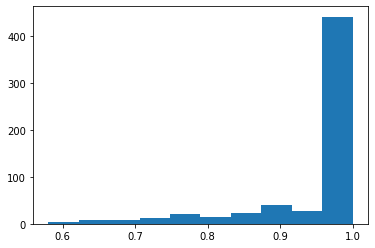

In [14]:
maxvals = net.net[:-1](xx).data.cpu().max(dim=1)[0]
plt.hist(maxvals)

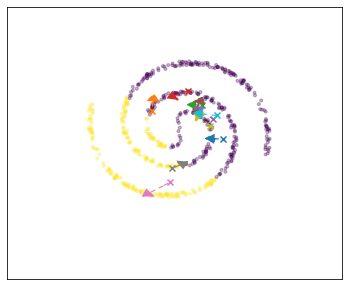

In [15]:
yout = net(xx)
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
d = net.net[-1].weight.data.cpu().t()*0.5 #+ net.net[-1].bias.data.cpu()


for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/01.0_viz_clf_vector_0.pdf", bbox_inches='tight')
plt.show()

In [16]:
net.net[-1].weight.data.cpu().t() + net.net[-1].bias.data.cpu()

tensor([[-0.2485, -0.0092],
        [-0.0441,  0.2601],
        [-0.1967, -0.0175],
        [-0.3581, -0.1586],
        [-0.3278,  0.2215],
        [ 0.0230,  0.2060],
        [-0.5148, -0.3211],
        [ 0.0926,  0.0755],
        [-0.2658,  0.2114],
        [-0.3825,  0.0274]])

In [17]:
net.net[1][0].shifter

Parameter containing:
tensor([[1.0002, 1.0010, 1.0002, 0.9988, 0.9996, 1.0005, 1.0080, 0.9916, 1.0001,
         0.9999]], device='cuda:0', requires_grad=True)

## Actively choosing Data points as weights (w.r.t. SGD)

In [18]:
def directional_similarity(point, direction, other_points):
    '''
    Calculates directional similarity
    point -> [m, dim]: point from which direction is found 
    direction -> [m, dim]: un-normalized direction in which to find similarity; OR negative gradient
    other_points -> [N, dim]: other valid points to find the direction
    '''
    
#     print(point.shape)
#     print(direction.shape)
#     print(other_points.shape)
    
    
    ### direction towards +ve x-axis
    direction = direction/torch.norm(direction, p=1, dim=-1, keepdim=True) ## always normalized

    vecs = other_points.unsqueeze(0)-point.unsqueeze(1)
    vecs_mag = torch.norm(vecs, p=1.5, dim=-1, keepdim=True)
    vecs_dirn = vecs/(vecs_mag+1e-11) ## 1e-B for stability
    
#     print(vecs_dirn.shape, direction.unsqueeze(2).shape)
#     yout = vecs_dirn@direction.t() ## gives importance to direction
    yout = torch.bmm(vecs_dirn, direction.unsqueeze(2))## gives importance to direction
#     print(yout.shape, vecs_mag.shape)
    yout = yout/(vecs_mag+1e-11+1) ## gives inportance to similarity
    return yout

In [19]:
num_points = 100
X1 = np.linspace(-1.0, 1.0, num_points)
X2 = np.linspace(0.0, 2.0, num_points)

# X1 = np.linspace(-0.6, -0.4, num_points)
# X2 = np.linspace(0.9, 1.1, num_points)

X1, X2 = np.meshgrid(X1, X2)

XX_grid = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)])

In [20]:
point = torch.Tensor([[-0.5, 1]])
direction = torch.Tensor([[1, 0]])

In [21]:
sim = directional_similarity(point, direction, XX_grid)

In [22]:
## reduce output variance
# sim = (sim.abs() ** (1/10)) *sim.sign()

tensor([-0.4343,  1.0101])


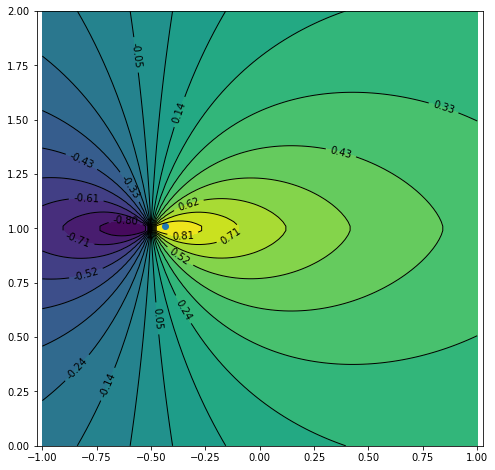

In [23]:
%matplotlib inline
LVLs = np.linspace(sim.min(), sim.max(), 20)

plt.figure(figsize=(8,8))
plt.contourf(X1, X2, sim.data.numpy().reshape(X1.shape), levels=LVLs)
cs = plt.contour(X1, X2, sim.data.numpy().reshape(X1.shape), levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")

xx_max = XX_grid[sim.argmax()]
plt.scatter(*xx_max)
plt.axis('equal')
print(xx_max)

In [24]:
class ResidualMLP(nn.Module):
    
    def __init__(self, h):
        super().__init__()
        self.net = nn.Sequential(
#             dtnn.DistanceTransformBase(2, h),
            dtnn.DistanceTransform(2, h),
            nn.Sequential(dtnn.ScaleShift(h, scale_init=10, shift_init=None), ### Shift is learnable, scale is fixed
                            nn.Softmax(dim=-1)),
            dtnn.OneActiv(h, mode="exp_1.6"),
            nn.Linear(h, 2),
            )
        self.net[0].centers.data = torch.randn_like(self.net[0].centers)/3.
        self.clf = nn.Linear(2, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.clf(x + self.net(x)))
#         return torch.sigmoid(self.clf(self.net(x)))

In [25]:
net = ResidualMLP(10).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.BCELoss()
# criterion = nn.MSELoss()

In [26]:
net.net[0].centers.shape

torch.Size([10, 2])

_________________________
Epoch: 99, Acc:0.61, Loss:0.6779798269271851
Epoch: 199, Acc:0.66, Loss:0.6568204760551453
Epoch: 299, Acc:0.70, Loss:0.6333640813827515
Epoch: 399, Acc:0.70, Loss:0.6064369678497314
Epoch: 499, Acc:0.71, Loss:0.5774919390678406
Epoch: 599, Acc:0.74, Loss:0.5485837459564209
Epoch: 699, Acc:0.79, Loss:0.521665632724762
Epoch: 799, Acc:0.78, Loss:0.4988149106502533
Epoch: 899, Acc:0.78, Loss:0.48084068298339844
Epoch: 999, Acc:0.77, Loss:0.46662381291389465


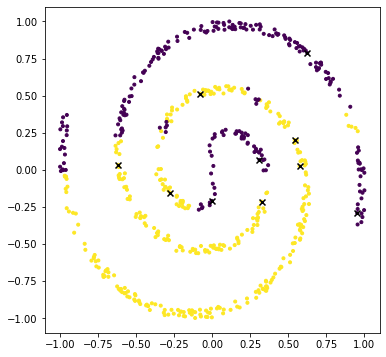

Epoch: 1099, Acc:0.69, Loss:0.5665640830993652
Epoch: 1199, Acc:0.73, Loss:0.5441634058952332
Epoch: 1299, Acc:0.74, Loss:0.5271199345588684
Epoch: 1399, Acc:0.74, Loss:0.51326984167099
Epoch: 1499, Acc:0.73, Loss:0.5011101365089417
Epoch: 1599, Acc:0.73, Loss:0.4901151657104492
Epoch: 1699, Acc:0.73, Loss:0.4803156554698944
Epoch: 1799, Acc:0.73, Loss:0.4716699719429016
Epoch: 1899, Acc:0.71, Loss:0.46405985951423645
Epoch: 1999, Acc:0.72, Loss:0.4572540521621704


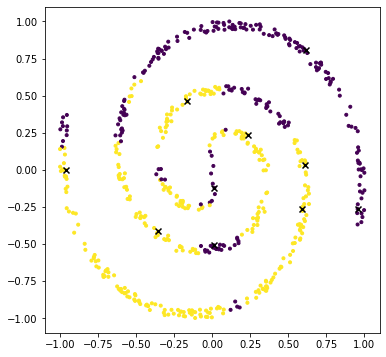

Epoch: 2099, Acc:0.75, Loss:0.4880293011665344
Epoch: 2199, Acc:0.75, Loss:0.4729888141155243
Epoch: 2299, Acc:0.75, Loss:0.46012839674949646
Epoch: 2399, Acc:0.75, Loss:0.4479299485683441
Epoch: 2499, Acc:0.76, Loss:0.43560531735420227
Epoch: 2599, Acc:0.77, Loss:0.4239319860935211
Epoch: 2699, Acc:0.77, Loss:0.41367441415786743
Epoch: 2799, Acc:0.78, Loss:0.4043239653110504
Epoch: 2899, Acc:0.78, Loss:0.39569011330604553
Epoch: 2999, Acc:0.79, Loss:0.3874260187149048


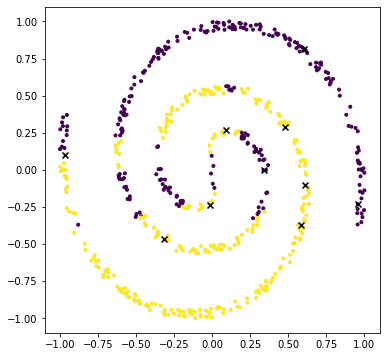

Epoch: 3099, Acc:0.72, Loss:0.5811964273452759
Epoch: 3199, Acc:0.72, Loss:0.5401951670646667
Epoch: 3299, Acc:0.72, Loss:0.5106494426727295
Epoch: 3399, Acc:0.73, Loss:0.48914286494255066
Epoch: 3499, Acc:0.73, Loss:0.4733196198940277
Epoch: 3599, Acc:0.74, Loss:0.46139460802078247
Epoch: 3699, Acc:0.75, Loss:0.45015355944633484
Epoch: 3799, Acc:0.76, Loss:0.43549033999443054
Epoch: 3899, Acc:0.79, Loss:0.4198474586009979
Epoch: 3999, Acc:0.81, Loss:0.407956600189209


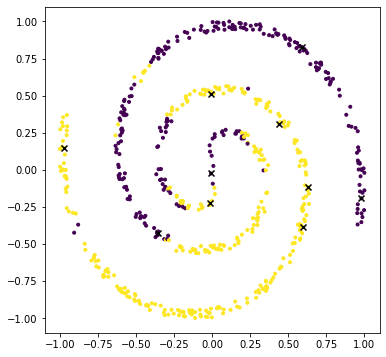

Epoch: 4099, Acc:0.76, Loss:0.4100649952888489
Epoch: 4199, Acc:0.77, Loss:0.39566537737846375
Epoch: 4299, Acc:0.77, Loss:0.38526859879493713
Epoch: 4399, Acc:0.76, Loss:0.3762688934803009
Epoch: 4499, Acc:0.80, Loss:0.36724382638931274
Epoch: 4599, Acc:0.82, Loss:0.35764312744140625
Epoch: 4699, Acc:0.82, Loss:0.3477393090724945
Epoch: 4799, Acc:0.83, Loss:0.33825671672821045
Epoch: 4899, Acc:0.84, Loss:0.3297555148601532
Epoch: 4999, Acc:0.85, Loss:0.3224489688873291


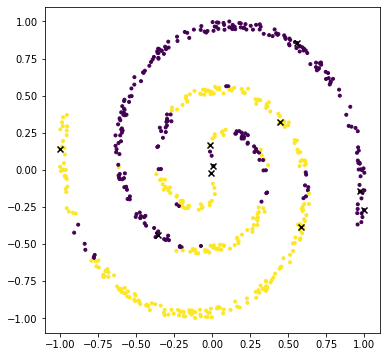

In [27]:
print("_________________________")
for epoch in range(5000):
    yout = net(xx)
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    ########################################################
    ### Do discrete optimization here
    if (epoch+0)%1000 == 0:
        sim = directional_similarity(
                    net.net[0].centers, 
                    -net.net[0].centers.grad, 
                    xx).squeeze(-1)
    #     print(sim.shape)

        sim_x = sim.argmax(dim=-1)
    #     print(sim_x)
    #     print(xx[sim_x])
        net.net[0].centers.data = xx[sim_x]
    
#     break
    ########################################################
        optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    else:
        net.net[0].centers.grad = None
        optimizer.step()

    if (epoch+1)%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = (yout.data.cpu().numpy()>0.5).astype(int)
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = net.net[0].centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

## Visualize the optimization Step by Step.
#### Try 1. Optimize centers once - Optimize Linear Layer a few steps (with new Optimizer)

In [28]:
net = ResidualMLP(10).to(device)
criterion = nn.BCELoss()

#### Optimize Center

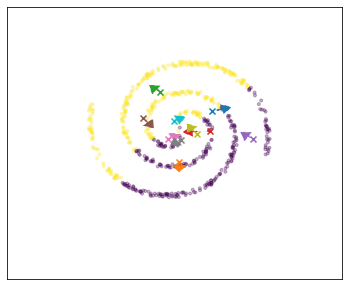

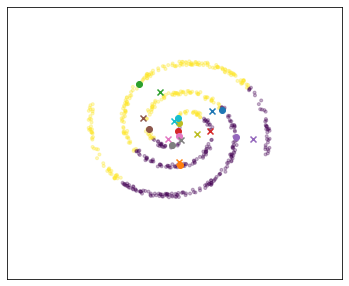

In [29]:
yout = net(xx)
loss = criterion(yout, yy)

optimizer.zero_grad()
loss.backward()
#####################################################
### Visualize directional Similarity

ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
d = -net.net[0].centers.grad.data.cpu()*10


for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)
plt.show()

old_centers = net.net[0].centers.data.cpu().numpy()

########################################################
### Do discrete optimization here
sim = directional_similarity(
            net.net[0].centers, 
            -net.net[0].centers.grad, 
            xx).squeeze(-1)

sim_x = sim.argmax(dim=-1)
# print(sim_x)
net.net[0].centers.data = xx[sim_x]
########################################################

ax = plt.figure(figsize=(6,5)).add_subplot()
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
oc = old_centers
for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'o')
    ax.scatter(oc[i,0], oc[i,1], color=color, marker= 'x')
    

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)
plt.show()

#### Optimize Rest

In [30]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

In [31]:
for i in range(1000):
    yout = net(xx)
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    net.net[0].centers.grad = None
    optimizer.step()
    
    if i%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {i}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

Epoch: 0, Acc:0.43, Loss:0.7438766956329346
Epoch: 100, Acc:0.73, Loss:0.5216555595397949
Epoch: 200, Acc:0.74, Loss:0.43621328473091125
Epoch: 300, Acc:0.81, Loss:0.3970249891281128
Epoch: 400, Acc:0.84, Loss:0.3713451623916626
Epoch: 500, Acc:0.86, Loss:0.35670486092567444
Epoch: 600, Acc:0.86, Loss:0.34696394205093384
Epoch: 700, Acc:0.87, Loss:0.3396912217140198
Epoch: 800, Acc:0.86, Loss:0.33481645584106445
Epoch: 900, Acc:0.87, Loss:0.33097875118255615


#### Output

Epoch: 4999, Acc:0.87, Loss:0.328511506319046


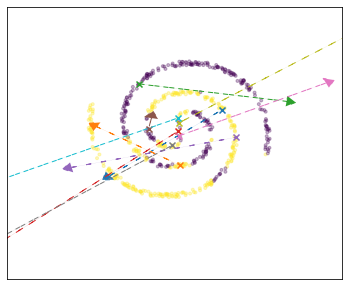

In [32]:
accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

with torch.no_grad():
    yout = net(xx)
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
d = net.net[-1].weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()


for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)
plt.show()

#### Directional Similarity Based On Gradient Magnitude

In [648]:
def directional_similarity_mag(point, direction, other_points):
    '''
    Calculates directional similarity
    point -> [m, dim]: point from which direction is found 
    direction -> [m, dim]: un-normalized direction in which to find similarity; OR negative gradient
    other_points -> [N, dim]: other valid points to find the direction
    '''
    
#     print(point.shape)
#     print(direction.shape)
#     print(other_points.shape)
    
    C = torch.Tensor([[0]]).to(point.device)
#     C = torch.norm(direction, p=2, dim=-1, keepdim=True)
#     print(C.shape)
    C = C.unsqueeze(1)
    
    ### direction towards +ve x-axis
#     direction = direction/torch.norm(direction, p=1, dim=-1, keepdim=True) ## always normalized
    vecs = other_points.unsqueeze(0)-point.unsqueeze(1)
    vecs_mag = torch.norm(vecs, p=2, dim=-1, keepdim=True)
#     print(vecs.shape, vecs_mag.shape, C.shape)
    vecs_dirn = vecs/(vecs_mag+1e-11+C) ## 1e-B for stability
    
#     print(vecs_dirn.shape, direction.unsqueeze(2).shape)
#     yout = vecs_dirn@direction.t() ## gives importance to direction
    yout = torch.bmm(vecs_dirn, direction.unsqueeze(2))## gives importance to direction
#     print(yout.shape, vecs_mag.shape)
    yout = yout/(vecs_mag+1e-11+C) ## gives inportance to similarity
    return yout.squeeze(-1)

In [769]:
def directional_similarity_mag_v2(point, direction, other_points):
    '''
    Calculates directional similarity
    point -> [m, dim]: point from which direction is found 
    direction -> [m, dim]: un-normalized direction in which to find similarity; OR negative gradient
    other_points -> [N, dim]: other valid points to find the direction
    '''
    
    LP = 2
    C = torch.norm(direction, p=LP, dim=-1, keepdim=True)
    C = C.unsqueeze(1)
    
#     ### direction towards +ve x-axis
    vecs = other_points.unsqueeze(0)-point.unsqueeze(1)
    vecs_mag = torch.norm(vecs, p=LP, dim=-1, keepdim=True)
    vecs_dirn = vecs/(vecs_mag+1e-11+C) ## 1e-B for stability
    
    yout = torch.bmm(vecs_dirn, direction.unsqueeze(2))## gives importance to direction
    yout = yout/(vecs_mag+1e-11+C) ## gives inportance to similarity
#     return (yout-C).squeeze(-1)


    LP = 2
#     C = torch.Tensor([[0]]).to(point.device)
    C = torch.norm(point+direction, p=LP, dim=-1, keepdim=True)
#     C = C.unsqueeze(1)
    
#     print(C)
    
    ### direction towards +ve x-axis
#     vecs = other_points.unsqueeze(0)-(point+direction).unsqueeze(1)
    vecs2 = other_points.unsqueeze(0)-(point+direction).unsqueeze(1)
    
    vecs2_mag = torch.norm(vecs, p=LP, dim=-1, keepdim=True)
    vecs2_dirn = vecs2/(vecs2_mag+1e-11+C) ## 1e-B for stability
    
    yout2 = torch.bmm(vecs2_dirn, direction.unsqueeze(2))## gives importance to direction
    yout2 = yout2/(vecs2_mag+1e-11+C) ## gives inportance to similarity
#     return yout.squeeze(-1)

#     print(yout.shape, vecs2_mag.shape)
    return (yout-yout2).squeeze(-1)

In [770]:
def directional_similarity_mag_v3(point, direction, other_points):
    '''
    Calculates directional similarity
    point -> [m, dim]: point from which direction is found 
    direction -> [m, dim]: un-normalized direction in which to find similarity; OR negative gradient
    other_points -> [N, dim]: other valid points to find the direction
    '''
    
    ### direction towards +ve x-axis

    vecs = other_points.unsqueeze(0)-point.unsqueeze(1)
    vecs_mag = torch.norm(vecs, p=2, dim=-1, keepdim=True)
    vecs_dirn = vecs/(vecs_mag+1e-11) ## 1e-B for stability
    
    direction = direction/torch.norm(direction, p=2, dim=-1, keepdim=True) ## always normalized

#     print(vecs_dirn.shape, direction.unsqueeze(2).shape)
#     yout = vecs_dirn@direction.t() ## gives importance to direction
    yout = torch.bmm(vecs_dirn, direction.unsqueeze(2))## gives importance to direction
#     print(yout.shape, vecs_mag.shape)
    yout = yout/(vecs_mag+1e-11+1) ## gives inportance to similarity
    return yout

In [771]:
def directional_similarity_mag_v4(point, direction, other_points):
    '''
    Calculates directional similarity
    point -> [m, dim]: point from which direction is found 
    direction -> [m, dim]: un-normalized direction in which to find similarity; OR negative gradient
    other_points -> [N, dim]: other valid points to find the direction
    '''
    
    LP = 2
    vecs = other_points.unsqueeze(0)-(point+direction).unsqueeze(1)
    vecs_mag = torch.norm(vecs, p=LP, dim=-1, keepdim=True)
    return 1-vecs_mag.squeeze(-1)

In [772]:
point = torch.Tensor([[-0.5, 1]])
direction = torch.Tensor([[0.5, 0.5]])*1

In [773]:
sim = directional_similarity_mag_v2(point, direction, XX_grid)
print(sim.max())

tensor(0.2986)


In [774]:
## reduce output variance
# sim = (sim.abs() ** (1/10)) *sim.sign()

tensor([[-0.3131, -0.3081]])


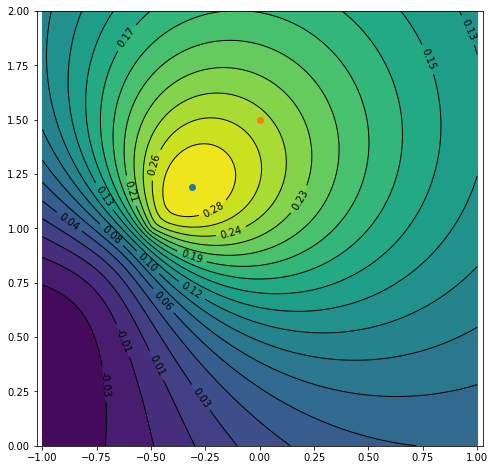

In [775]:
%matplotlib inline
LVLs=300
LVLs = np.linspace(sim.min(), sim.max(), 20)

plt.figure(figsize=(8,8))
plt.contourf(X1, X2, sim.data.numpy().reshape(X1.shape), levels=LVLs)
cs = plt.contour(X1, X2, sim.data.numpy().reshape(X1.shape), levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")

xx_max = XX_grid[sim.argmax()]
plt.scatter(*xx_max)
plt.scatter(*(point+direction).t())
plt.axis('equal')
print(xx_max-direction-point) ## should give zero for valid maximum


In [727]:
class ResidualMLP(nn.Module):
    
    def __init__(self, h, scale=10):
        super().__init__()
        self.net = nn.Sequential(
#             dtnn.DistanceTransformBase(2, h),
            dtnn.DistanceTransform(2, h),
            nn.Sequential(dtnn.ScaleShift(h, scale_init=scale, shift_init=None), ### Shift is learnable, scale is fixed
                            nn.Softmax(dim=-1)),
            dtnn.OneActiv(h, mode="exp_1.6"),
            nn.Linear(h, 2),
            )
        self.net[0].centers.data = torch.randn_like(self.net[0].centers)/3.
        self.clf = nn.Linear(2, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.clf(x + self.net(x)))
#         return torch.sigmoid(self.clf(self.net(x)))

## Visualize the optimization Step by Step.
#### Try 1. Optimize centers once - Optimize Linear Layer a few steps (with new Optimizer)

In [728]:
net = ResidualMLP(10).to(device)
criterion = nn.BCELoss()

#### Optimize Center

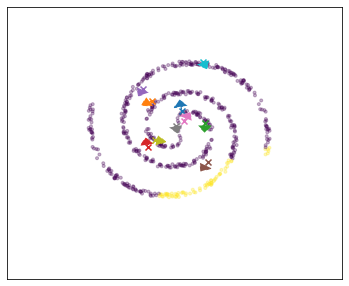

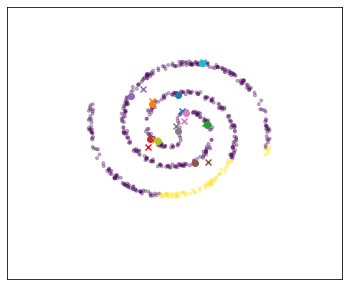

In [729]:
LR = 0.1

yout = net(xx)
loss = criterion(yout, yy)

optimizer.zero_grad()
loss.backward()
#####################################################
### Visualize directional Similarity

ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
d = -net.net[0].centers.grad.data.cpu()*10


for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)
plt.show()

old_centers = net.net[0].centers.data.cpu().numpy()

########################################################
### Do discrete optimization here
sim = directional_similarity_mag(
            net.net[0].centers, 
            -net.net[0].centers.grad * LR, 
            xx)

sim_x = sim.argmax(dim=-1)
net.net[0].centers.data = xx[sim_x]
########################################################

ax = plt.figure(figsize=(6,5)).add_subplot()
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
oc = old_centers
for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'o')
    ax.scatter(oc[i,0], oc[i,1], color=color, marker= 'x')
    

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)
plt.show()

#### Optimize Rest

In [730]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

In [731]:
for i in range(1000):
    yout = net(xx)
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    net.net[0].centers.grad = None
    optimizer.step()
    
    if i%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {i}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

Epoch: 0, Acc:0.62, Loss:0.6671016812324524
Epoch: 100, Acc:0.77, Loss:0.4581594467163086
Epoch: 200, Acc:0.73, Loss:0.38783153891563416
Epoch: 300, Acc:0.75, Loss:0.3732430338859558
Epoch: 400, Acc:0.76, Loss:0.35987070202827454
Epoch: 500, Acc:0.78, Loss:0.34323740005493164
Epoch: 600, Acc:0.80, Loss:0.3338482677936554
Epoch: 700, Acc:0.81, Loss:0.32870998978614807
Epoch: 800, Acc:0.81, Loss:0.3180125653743744
Epoch: 900, Acc:0.89, Loss:0.2611759901046753


#### Output

Epoch: 4999, Acc:0.91, Loss:0.2104833722114563


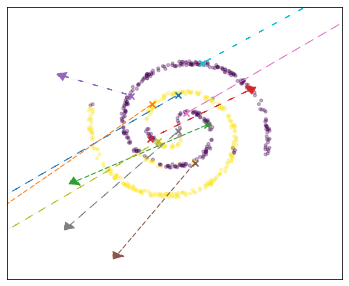

In [732]:
accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

with torch.no_grad():
    yout = net(xx)
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
d = net.net[-1].weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()


for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)
plt.show()

## Train At Once

In [752]:
class ResidualMLP(nn.Module):
    
    def __init__(self, h, scale=10):
        super().__init__()
        self.net = nn.Sequential(
#             dtnn.DistanceTransformBase(2, h),
            dtnn.DistanceTransform(2, h),
            nn.Sequential(dtnn.ScaleShift(h, scale_init=scale, shift_init=None), ### Shift is learnable, scale is fixed
                            nn.Softmax(dim=-1)),
            dtnn.OneActiv(h, mode="exp_1.6"),
            nn.Linear(h, 2),
            )
        self.net[0].centers.data = torch.randn_like(self.net[0].centers)/3.
        self.clf = nn.Linear(2, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.clf(x + self.net(x)))
#         return torch.sigmoid(self.clf(self.net(x)))

In [753]:
net = ResidualMLP(10, scale=10.0).to(device)

lr = 0.01
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
criterion = nn.BCELoss()
# criterion = nn.MSELoss()
LR = 0.3
min_sim = 0.0

In [754]:
net.net[0].centers.shape, net.net[-1].weight.shape

(torch.Size([10, 2]), torch.Size([2, 10]))

In [755]:
# torch.norm(net.net[-1].weight.data, dim=1, keepdim=True)

Epoch: 99, Acc:0.78, Loss:0.4377959370613098
Epoch: 199, Acc:0.82, Loss:0.3490935266017914
Epoch: 299, Acc:0.88, Loss:0.3069135248661041
Epoch: 399, Acc:0.89, Loss:0.2886263132095337
Epoch: 499, Acc:0.89, Loss:0.278446227312088
Epoch: 599, Acc:0.90, Loss:0.26695194840431213
Epoch: 699, Acc:0.89, Loss:0.26186367869377136
Epoch: 799, Acc:0.89, Loss:0.26045888662338257
Epoch: 899, Acc:0.89, Loss:0.2595900595188141
Epoch: 999, Acc:0.89, Loss:0.2590223252773285


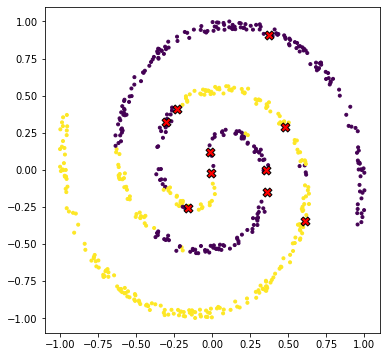

Epoch: 1099, Acc:0.89, Loss:0.2940203547477722
Epoch: 1199, Acc:0.89, Loss:0.2666715979576111
Epoch: 1299, Acc:0.91, Loss:0.24895185232162476
Epoch: 1399, Acc:0.92, Loss:0.2387075424194336
Epoch: 1499, Acc:0.92, Loss:0.23179186880588531
Epoch: 1599, Acc:0.92, Loss:0.2264610379934311
Epoch: 1699, Acc:0.92, Loss:0.2223871648311615
Epoch: 1799, Acc:0.92, Loss:0.21924841403961182
Epoch: 1899, Acc:0.93, Loss:0.21656428277492523
Epoch: 1999, Acc:0.93, Loss:0.2141205072402954


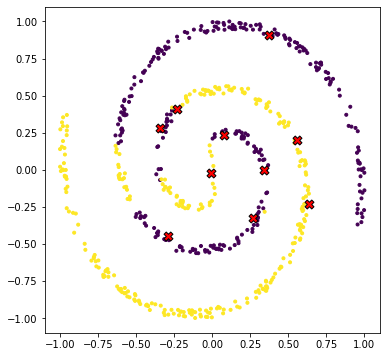

Epoch: 2099, Acc:0.96, Loss:0.162553071975708
Epoch: 2199, Acc:0.96, Loss:0.1577269583940506
Epoch: 2299, Acc:0.96, Loss:0.15404996275901794
Epoch: 2399, Acc:0.96, Loss:0.15082257986068726
Epoch: 2499, Acc:0.96, Loss:0.14708870649337769
Epoch: 2599, Acc:0.96, Loss:0.14230914413928986
Epoch: 2699, Acc:0.97, Loss:0.13706673681735992
Epoch: 2799, Acc:0.97, Loss:0.13205863535404205
Epoch: 2899, Acc:0.97, Loss:0.12782420217990875
Epoch: 2999, Acc:0.97, Loss:0.12501706182956696


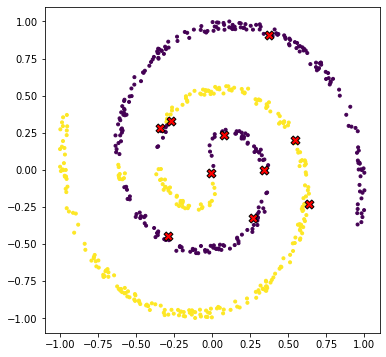

Epoch: 3099, Acc:0.96, Loss:0.18004027009010315
Epoch: 3199, Acc:0.97, Loss:0.12417753040790558
Epoch: 3299, Acc:0.98, Loss:0.1126035824418068
Epoch: 3399, Acc:0.98, Loss:0.10602180659770966
Epoch: 3499, Acc:0.98, Loss:0.1008538007736206
Epoch: 3599, Acc:0.98, Loss:0.09744197875261307
Epoch: 3699, Acc:0.98, Loss:0.09470698982477188
Epoch: 3799, Acc:0.98, Loss:0.09228428453207016
Epoch: 3899, Acc:0.99, Loss:0.089656300842762
Epoch: 3999, Acc:0.99, Loss:0.08625476062297821


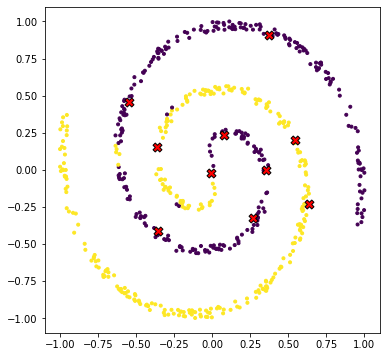

Epoch: 4099, Acc:1.00, Loss:0.03786792978644371
Epoch: 4199, Acc:1.00, Loss:0.03142212703824043
Epoch: 4299, Acc:1.00, Loss:0.028088510036468506
Epoch: 4399, Acc:1.00, Loss:0.025867028161883354
Epoch: 4499, Acc:1.00, Loss:0.02401551976799965
Epoch: 4599, Acc:1.00, Loss:0.022388843819499016
Epoch: 4699, Acc:1.00, Loss:0.020920228213071823
Epoch: 4799, Acc:1.00, Loss:0.019576091319322586
Epoch: 4899, Acc:1.00, Loss:0.018360449001193047
Epoch: 4999, Acc:1.00, Loss:0.017454812303185463


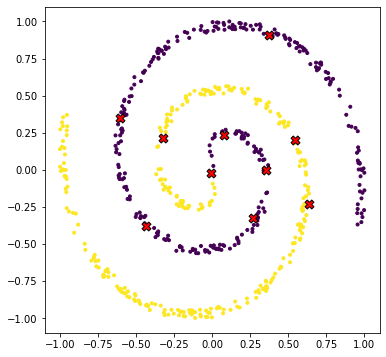

Epoch: 5099, Acc:1.00, Loss:0.014300341717898846
Epoch: 5199, Acc:1.00, Loss:0.01328238844871521
Epoch: 5299, Acc:1.00, Loss:0.012511737644672394
Epoch: 5399, Acc:1.00, Loss:0.01190820150077343
Epoch: 5499, Acc:1.00, Loss:0.011386623606085777
Epoch: 5599, Acc:1.00, Loss:0.010915787890553474
Epoch: 5699, Acc:1.00, Loss:0.010483307763934135
Epoch: 5799, Acc:1.00, Loss:0.010082184337079525
Epoch: 5899, Acc:1.00, Loss:0.009707614779472351
Epoch: 5999, Acc:1.00, Loss:0.009356061927974224


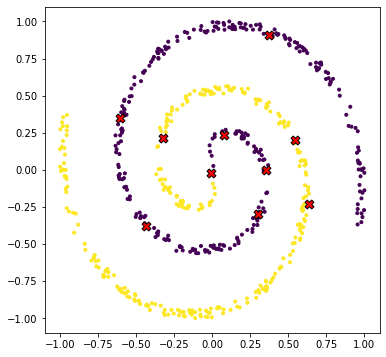

Epoch: 6099, Acc:1.00, Loss:0.009027881547808647
Epoch: 6199, Acc:1.00, Loss:0.008714176714420319
Epoch: 6299, Acc:1.00, Loss:0.008416449651122093
Epoch: 6399, Acc:1.00, Loss:0.008133112452924252
Epoch: 6499, Acc:1.00, Loss:0.007862906903028488
Epoch: 6599, Acc:1.00, Loss:0.0076047154143452644
Epoch: 6699, Acc:1.00, Loss:0.007357646711170673
Epoch: 6799, Acc:1.00, Loss:0.007120910566300154
Epoch: 6899, Acc:1.00, Loss:0.006893824320286512
Epoch: 6999, Acc:1.00, Loss:0.0066757649183273315


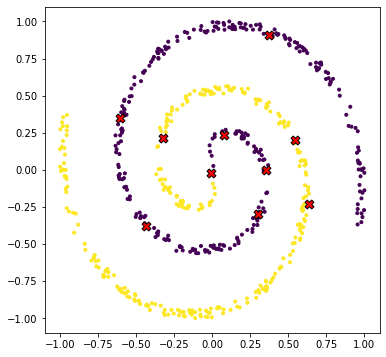

Epoch: 7099, Acc:1.00, Loss:0.006468271836638451
Epoch: 7199, Acc:1.00, Loss:0.006266737822443247
Epoch: 7299, Acc:1.00, Loss:0.006083316169679165
Epoch: 7399, Acc:1.00, Loss:0.005884266458451748
Epoch: 7499, Acc:1.00, Loss:0.005705641582608223
Epoch: 7599, Acc:1.00, Loss:0.005533446092158556
Epoch: 7699, Acc:1.00, Loss:0.005367377772927284
Epoch: 7799, Acc:1.00, Loss:0.005207161419093609
Epoch: 7899, Acc:1.00, Loss:0.005052550695836544
Epoch: 7999, Acc:1.00, Loss:0.004903314169496298


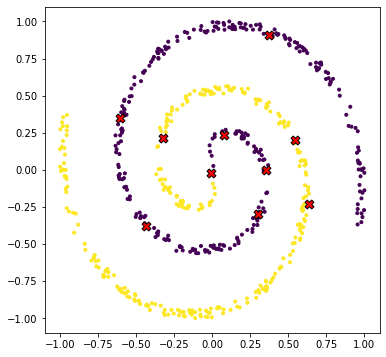

Epoch: 8099, Acc:1.00, Loss:0.004760625306516886
Epoch: 8199, Acc:1.00, Loss:0.004621397238224745
Epoch: 8299, Acc:1.00, Loss:0.0044868942350149155
Epoch: 8399, Acc:1.00, Loss:0.004356917925179005
Epoch: 8499, Acc:1.00, Loss:0.004231309052556753
Epoch: 8599, Acc:1.00, Loss:0.004109863191843033
Epoch: 8699, Acc:1.00, Loss:0.0039924317970871925
Epoch: 8799, Acc:1.00, Loss:0.003878850257024169
Epoch: 8899, Acc:1.00, Loss:0.0037689758464694023
Epoch: 8999, Acc:1.00, Loss:0.003662656294181943


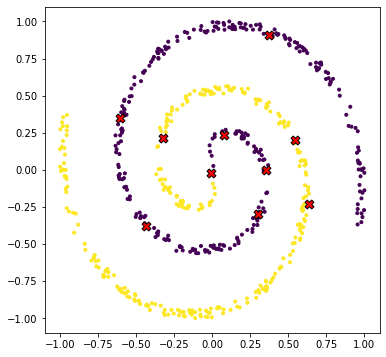

Epoch: 9099, Acc:1.00, Loss:0.0035607824102044106
Epoch: 9199, Acc:1.00, Loss:0.0034611504524946213
Epoch: 9299, Acc:1.00, Loss:0.003364684758707881
Epoch: 9399, Acc:1.00, Loss:0.003271267982199788
Epoch: 9499, Acc:1.00, Loss:0.0031808477360755205
Epoch: 9599, Acc:1.00, Loss:0.00313433981500566
Epoch: 9699, Acc:1.00, Loss:0.0030457056127488613
Epoch: 9799, Acc:1.00, Loss:0.002971719251945615
Epoch: 9899, Acc:1.00, Loss:0.0029001112561672926
Epoch: 9999, Acc:1.00, Loss:0.002830276731401682


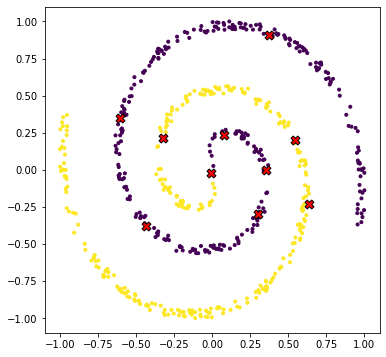

In [756]:
for epoch in range(10000):
    wnorm = torch.norm(net.net[-1].weight.data, dim=0, keepdim=True)
    net.net[-1].weight.data *= wnorm.clamp(0.01, 2.0)/wnorm
    
    yout = net(xx)
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    ########################################################
    ### Do discrete optimization here
    if (epoch+0)%1000 <= 0:
        sim = directional_similarity_mag_v4(
                    net.net[0].centers, 
                    -net.net[0].centers.grad * LR, 
                    xx)
        
        ## Method 1 (no filtering)
        if epoch == 0:
            sim_x = sim.argmax(dim=-1)
            net.net[0].centers.data = xx[sim_x]
        else:
        ## Method 2 (filtering)
            maxval, maxidx = sim.max(dim=-1)
            valid_mask = maxval > min_sim
            net.net[0].centers.data[valid_mask] = xx[maxidx][valid_mask]
    
    ########################################################
#         optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    else:
        net.net[0].centers.grad = None
        optimizer.step()

    if (epoch+1)%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = (yout.data.cpu().numpy()>0.5).astype(int)
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = net.net[0].centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], facecolor='red', marker= 'X', edgecolor='k', s=80)
        plt.show()

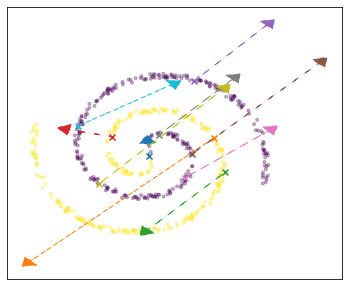

In [757]:
yout = net(xx)
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
d = net.net[-1].weight.data.cpu().t()*1.0 + net.net[-1].bias.data.cpu()


for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/01.0_viz_clf_vector_0.pdf", bbox_inches='tight')
plt.show()

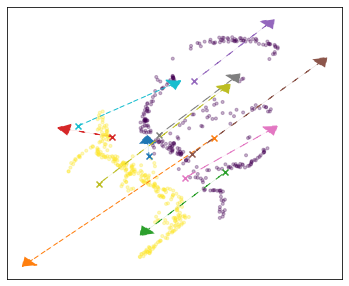

In [758]:
dev = (xx+net.net(xx)*1.0).data.cpu()

ax = plt.figure(figsize=(6,5)).add_subplot()

ax.scatter(dev[:,0], dev[:,1], c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
d = net.net[-1].weight.data.cpu().t()*1.0 + net.net[-1].bias.data.cpu()
for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/01.0_viz_clf_vector_1.pdf", bbox_inches='tight')
plt.show()